# Random Forest Modelling Notebook for DEFRA - All Targets

This notebook trains Random Forest models for all site_pollutant combinations in the DEFRA network.

**Input:** `data/defra/ml_prep_all` folder  
**Output:** `data/defra/rf_model_all` folder  
**Reference:** Geron's *Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow* 3rd edition, heavy usage of scikit-learn documentation.

---

## What this notebook does

1. Load prepared data from ml_prep_all output.
2. Identify all pollution targets (40 site_pollutant combinations).
3. Tune hyperparameters per pollutant type (6 tuning runs).
4. Train a Random Forest model for each target with progress tracking.
5. Evaluate using RMSE, MAE, r2 for all models.
6. Analyse results by pollutant type.
7. Save all trained models.

---

## Why DEFRA?

DEFRA (Department for Environment, Food and Rural Affairs) operates the Automatic Urban and Rural Network (AURN), the UK's statutory national air quality monitoring network. While LAQN focuses specifically on London with dense coverage, DEFRA provides nationally standardised measurements with rigorous quality assurance.

### Key DEFRA characteristics:

- **Higher data completeness:** 91.2% vs LAQN's 87.1%.
- **Fewer but higher-quality stations:** 40 site-pollutant combinations vs LAQN's 141.
- **Standardised methodology:** National monitoring protocols ensure consistency.
- **Direct comparison:** Enables testing whether data quality beats data quantity.

---

## Training approach

Instead of using GridSearchCV or MultiOutputRegressor which trains all 40 targets simultaneously, I train each site_pollutant combination separately. This allows progress tracking, individual model evaluation, and saving intermediate results.

**Targets:** 6 pollutants across 40 site_pollutant combinations.

- NO2: 13 sites.
- O3: 8 sites.
- PM10: 7 sites.
- PM25: 7 sites.
- SO2: 3 sites.
- CO: 2 sites.

---

## Why only 6 pollutants?

DEFRA's AURN network in the Greater London area monitors these six regulatory pollutants, matching the same pollutants available in LAQN. This enables direct comparison between the two networks using identical pollutant types, testing whether DEFRA's higher data quality compensates for its smaller station count.

---

## Dataset comparison

| Metric | LAQN | DEFRA |
|--------|------|-------|
| Site-pollutant combinations | 141 | 40 |
| Training samples | 17,107 | 17,036 |
| Flattened features | 1,740 | 528 |
| Original features | 145 | 44 |
| Data completeness | 87.1% | 91.2% |

DEFRA has approximately 65% fewer features but similar sample count with higher data quality.

---

## Development history

Unlike LAQN which required multiple failed attempts, DEFRA training benefited from lessons learned.

**LAQN challenges (solved before DEFRA):**

- GridSearchCV memory crashes on my local laptop.
- MultiOutputRegressor still too memory-intensive.
- Required HalvingGridSearchCV and checkpoint saving.

**DEFRA approach (applied directly):**

- Used HalvingGridSearchCV from the start.
- Tuned one representative site per pollutant (6 tuning runs).
- Applied optimal params to all sites of that pollutant type.
- Checkpoint saving every 10 models for safety.
- Memory-safe parameters (max_depth capped at 15, n_estimators at 100).
- To save some time, I ran this notebook on Google Colab.

**Training times:**

- Tuning: approximately 13 minutes (vs LAQN's longer tuning due to more features).
- Full training: Significantly faster due to fewer features (528 vs 1,740).

---

## Single-station baseline results

From the initial single-station experiment (London_Haringey_Priory_Park_South_NO2):

| Metric | LAQN (EN5_NO2) | DEFRA (Haringey) | Winner |
|--------|----------------|------------------|--------|
| Test r2 | 0.814 | 0.855 | DEFRA |
| Test RMSE | 0.050 | 0.033 | DEFRA |
| Test MAE | 0.034 | 0.023 | DEFRA |

This shows that data quality beats data quantity. DEFRA achieved 34% lower RMSE with 39% fewer features. The all stations training tests whether this advantage holds across all pollutant types.

In [2]:
#Imports as usual at the top.
import numpy as np
import pandas as pd
import joblib
import gc
import time
from pathlib import Path
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import matplotlib.pyplot as plt

In [3]:
#Paths as second, the folders for loading and saving the results.
base_dir = Path.cwd().parent.parent / "data" / "defra"
ml_prep_dir = base_dir / "ml_prep_all"
rf_output_dir = base_dir / "rf_model_all"
rf_output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = rf_output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"Loading from: {ml_prep_dir}")
print(f"Saving to: {rf_output_dir}")

Loading from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all
Saving to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all


## 1) Load prepared data

The ml_prep_all notebook created:
- `X_train_rf.npy`: Flattened training features (17,036 samples × 528 features).
- `X_val_rf.npy`: Flattened validation features.
- `X_test_rf.npy`: Flattened test features.
- `y_train.npy`, `y_val.npy`, `y_test.npy`: Target values (44 features each).
- `rf_feature_names.joblib`: Feature names for interpretability.
- `scaler.joblib`: MinMaxScaler to reverse normalisation.

The flattening was necessary because Random Forest expects 2D input (samples, features), but the original sequences were 3D (samples, 12 timesteps, 44 features).

12 × 44 = 528 flattened features per sample.

### DEFRA vs LAQN Comparison

| Metric             | LAQN   | DEFRA  |
| ------------------ | ------ | ------ |
| Training samples   | 17,107 | 17,036 |
| Original features  | 145    | 44     |
| Timesteps          | 12     | 12     |
| Flattened features | 1,740  | 528    |
| Target features    | 145    | 44     |



In [4]:
X_train_rf = np.load(ml_prep_dir / "X_train_rf.npy")
X_val_rf = np.load(ml_prep_dir / "X_val_rf.npy")
X_test_rf = np.load(ml_prep_dir / "X_test_rf.npy")
y_train = np.load(ml_prep_dir / "y_train.npy")
y_val = np.load(ml_prep_dir / "y_val.npy")
y_test = np.load(ml_prep_dir / "y_test.npy")
feature_names = joblib.load(ml_prep_dir / "feature_names.joblib")
try:
    rf_feature_names = joblib.load(ml_prep_dir / "rf_feature_names.joblib")
except:
    rf_feature_names = [f"feature_{i}" for i in range(X_train_rf.shape[1])]

print(f"X_train_rf: {X_train_rf.shape}")
print(f"y_train: {y_train.shape}")
print(f"Features: {len(feature_names)}")

X_train_rf: (17036, 528)
y_train: (17036, 44)
Features: 44



    X_train_rf: (17036, 528)
    y_train: (17036, 44)
    Features: 44

## 2) Identify pollution targets:

The y array has 44 columns. Looking at feature_names, the last 4 are temporal features (hour, day_of_week, month, is_weekend) which are inputs not targets.

The remaining 40 columns are site_pollutant combinations like London_Bloomsbury_NO2, Borehamwood_Meadow_Park_PM10 etc. These are what I want to predict.

In [6]:
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']

def get_pollutant_type(name):
    for poll in ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']:
        if poll in name:
            return poll
    return 'Other'

pollution_targets = []
target_mapping = {}
targets_by_pollutant = {}

for i, name in enumerate(feature_names):
    if name not in temporal_cols:
        pollution_targets.append(name)
        target_mapping[name] = i
        poll = get_pollutant_type(name)
        if poll not in targets_by_pollutant:
            targets_by_pollutant[poll] = []
        targets_by_pollutant[poll].append(name)

print(f"Pollution targets: {len(pollution_targets)}")
print("\nTargets by pollutant:")
for poll, targets in sorted(targets_by_pollutant.items()):
    print(f"  {poll}: {len(targets)} stations")

Pollution targets: 40

Targets by pollutant:
  CO: 2 stations
  NO2: 13 stations
  O3: 8 stations
  PM10: 7 stations
  PM25: 7 stations
  SO2: 3 stations


    Pollution targets: 40

    Targets by pollutant:
    CO: 2 stations
    NO2: 13 stations
    O3: 8 stations
    PM10: 7 stations
    PM25: 7 stations
    SO2: 3 stations

## 3) Hyperparameter tuning per pollutant type

Rather than tuning all 40 models individually with GridSearchCV (which was inefficient), I tune separately for each pollutant type using HalvingGridSearchCV.

### Why HalvingGridSearchCV instead of GridSearchCV?

From scikit-learn documentation:
> "Successive Halving is an iterative selection process. The first iteration is run with a small amount of resources. Only some candidates are selected to go on to the next iteration, which will be allocated more resources."

This is more efficient than exhaustive GridSearchCV because it eliminates poor parameter combinations early.

### Tuning strategy

For each pollutant:
1. Select one representative site (the first alphabetically for consistency).
2. Run HalvingGridSearchCV to find optimal params.
3. Store those params to use for all sites measuring that pollutant.

This gives 6 tuning runs instead of 40, balancing accuracy and efficiency.

### Key hyperparameters to tune for Random Forest

| Parameter | Description | Effect |
|-----------|-------------|--------|
| n_estimators | Number of trees | More trees = better accuracy but slower. |
| max_depth | Maximum tree depth | Limits complexity, prevents overfitting. |
| min_samples_split | Minimum samples to split node | Higher = simpler trees. |
| min_samples_leaf | Minimum samples in leaf | Higher = smoother predictions. |

Source: scikit-learn (no date) *sklearn.ensemble.RandomForestRegressor*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [11]:
# Representative targets
representative_targets = {}
for pollutant, targets in targets_by_pollutant.items():
    if pollutant != 'Other':
        representative_targets[pollutant] = sorted(targets)[0]

print("Representative targets for tuning:")
for poll, target in sorted(representative_targets.items()):
    print(f"  {poll}: {target}")

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
print(f"\nParameter grid: 24 combinations")

Representative targets for tuning:
  CO: London_Marylebone_Road_CO
  NO2: Borehamwood_Meadow_Park_NO2
  O3: London_Bloomsbury_O3
  PM10: Borehamwood_Meadow_Park_PM10
  PM25: Borehamwood_Meadow_Park_PM25
  SO2: London_Bloomsbury_SO2

Parameter grid: 24 combinations


    Representative targets for tuning:
    CO: London_Marylebone_Road_CO
    NO2: Borehamwood_Meadow_Park_NO2
    O3: London_Bloomsbury_O3
    PM10: Borehamwood_Meadow_Park_PM10
    PM25: Borehamwood_Meadow_Park_PM25
    SO2: London_Bloomsbury_SO2

    Parameter grid: 24 combinations

In [ ]:
print("Hyperparameter tuning per pollutant type")
print("=" * 40)

best_params_by_pollutant = {}
tuning_results = []
total_tuning_start = time.time()

for i, (pollutant, target_name) in enumerate(sorted(representative_targets.items())):
    target_idx = target_mapping[target_name]
    print(f"\n[{i+1}/{len(representative_targets)}] Tuning {pollutant} using {target_name}")
    
    tuning_start = time.time()
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    halving_search = HalvingGridSearchCV(
        rf, param_grid, cv=3, scoring='r2', factor=2,
        min_resources='smallest', aggressive_elimination=False,
        n_jobs=-1, verbose=1, random_state=42
    )
    halving_search.fit(X_train_rf, y_train[:, target_idx])
    
    tuning_time = time.time() - tuning_start
    best_params_by_pollutant[pollutant] = halving_search.best_params_
    
    tuning_results.append({
        'pollutant': pollutant, 'target': target_name,
        'best_score': halving_search.best_score_, 'time': tuning_time,
        **halving_search.best_params_
    })
    
    print(f"Best CV R2: {halving_search.best_score_:.4f}, Time: {tuning_time/60:.1f}min")
    del halving_search; gc.collect()

total_tuning_time = time.time() - total_tuning_start
print(f"\nTotal tuning time: {total_tuning_time/60:.1f} minutes")

Hyperparameter tuning per pollutant type

[1/6] Tuning CO using London_Marylebone_Road_CO
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan -83.43526986
 -75.04008106 -83.20454644 -37.682934   -35.99147528 -39.31711959
 -36.61819561 -74.21117034 -83.43526986 -75.04008106 -35.99147528
 -37.682934  ]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan -83.43526986
 -75.04008106 -83.20454644 -37.682934   -35.99147528 -39.31711959
 -36.61819561 -74.21117034 -83.43526986 -75.04008106 -35.99147528
 -37.682934     0.21337726   0.21231286   0.21231286   0.20493577
   0.20587288   0.20587288]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan -83.43526986
 -75.04008106 -83.20454644 -37.682934   -35.99147528 -39.31711959
 -36.61819561 -74.21117034 -83.43526986 -75.04008106 -35.99147528
 -37.682934     0.21337726   0.21231286   0.21231286   0.20493577
   0.20587288   0.20587288   0.64243372   0.64243372   0.64314115]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan -83.43526986
 -75.04008106 -83.20454644 -37.682934   -35.99147528 -39.31711959
 -36.61819561 -74.21117034 -83.43526986 -75.04008106 -35.99147528
 -37.682934     0.21337726   0.21231286   0.21231286   0.20493577
   0.20587288   0.20587288   0.64243372   0.64243372   0.64314115
   0.71683573   0.71821261]
  warnings.warn(


Best CV R2: 0.7182, Time: 2.3min

[2/6] Tuning NO2 using Borehamwood_Meadow_Park_NO2
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.71605854 -0.80982391 -1.23940559 -0.67445274 -0.68242206 -0.67549939
 -0.70095941 -0.65024414 -0.71605854 -0.80982391 -0.68242206 -0.67445274]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.71605854 -0.80982391 -1.23940559 -0.67445274 -0.68242206 -0.67549939
 -0.70095941 -0.65024414 -0.71605854 -0.80982391 -0.68242206 -0.67445274
  0.36133044  0.36133044  0.35342844  0.34770505  0.34770505  0.39448205]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.71605854 -0.80982391 -1.23940559 -0.67445274 -0.68242206 -0.67549939
 -0.70095941 -0.65024414 -0.71605854 -0.80982391 -0.68242206 -0.67445274
  0.36133044  0.36133044  0.35342844  0.34770505  0.34770505  0.39448205
  0.55546542  0.55546542  0.59393902]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.71605854 -0.80982391 -1.23940559 -0.67445274 -0.68242206 -0.67549939
 -0.70095941 -0.65024414 -0.71605854 -0.80982391 -0.68242206 -0.67445274
  0.36133044  0.36133044  0.35342844  0.34770505  0.34770505  0.39448205
  0.55546542  0.55546542  0.59393902  0.72497815  0.71884276]
  warnings.warn(


Best CV R2: 0.7250, Time: 1.1min

[3/6] Tuning O3 using London_Bloomsbury_O3
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.63525782 -0.6391978  -0.7209055  -0.53338396 -0.57254178 -0.557874
 -0.61359849 -0.61660238 -0.63525782 -0.6391978  -0.57254178 -0.53338396]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.63525782 -0.6391978  -0.7209055  -0.53338396 -0.57254178 -0.557874
 -0.61359849 -0.61660238 -0.63525782 -0.6391978  -0.57254178 -0.53338396
  0.37991237  0.36359927  0.36359927  0.36388902  0.35447837  0.35447837]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.63525782 -0.6391978  -0.7209055  -0.53338396 -0.57254178 -0.557874
 -0.61359849 -0.61660238 -0.63525782 -0.6391978  -0.57254178 -0.53338396
  0.37991237  0.36359927  0.36359927  0.36388902  0.35447837  0.35447837
  0.66429478  0.67060378  0.66600473]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.63525782 -0.6391978  -0.7209055  -0.53338396 -0.57254178 -0.557874
 -0.61359849 -0.61660238 -0.63525782 -0.6391978  -0.57254178 -0.53338396
  0.37991237  0.36359927  0.36359927  0.36388902  0.35447837  0.35447837
  0.66429478  0.67060378  0.66600473  0.83646766  0.84488766]
  warnings.warn(


Best CV R2: 0.8449, Time: 2.1min

[4/6] Tuning PM10 using Borehamwood_Meadow_Park_PM10
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -1.58015517 -1.88689029 -1.79923773 -1.98300677 -1.95934657 -2.03065142
 -2.32374202 -1.81192517 -1.58015517 -1.88689029 -1.95934657 -1.98300677]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -1.58015517 -1.88689029 -1.79923773 -1.98300677 -1.95934657 -2.03065142
 -2.32374202 -1.81192517 -1.58015517 -1.88689029 -1.95934657 -1.98300677
  0.15060805  0.15060805  0.15019695  0.1689901   0.18097189  0.18097189]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -1.58015517 -1.88689029 -1.79923773 -1.98300677 -1.95934657 -2.03065142
 -2.32374202 -1.81192517 -1.58015517 -1.88689029 -1.95934657 -1.98300677
  0.15060805  0.15060805  0.15019695  0.1689901   0.18097189  0.18097189
  0.71511803  0.69470981  0.69470981]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -1.58015517 -1.88689029 -1.79923773 -1.98300677 -1.95934657 -2.03065142
 -2.32374202 -1.81192517 -1.58015517 -1.88689029 -1.95934657 -1.98300677
  0.15060805  0.15060805  0.15019695  0.1689901   0.18097189  0.18097189
  0.71511803  0.69470981  0.69470981  0.66325716  0.6568204 ]
  warnings.warn(


Best CV R2: 0.6633, Time: 1.0min

[5/6] Tuning PM25 using Borehamwood_Meadow_Park_PM25
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -5.11427461 -4.55712163 -4.95892707 -3.70902794 -3.96862822 -3.48897191
 -3.96627915 -4.40092243 -5.11427461 -4.55712163 -3.96862822 -3.70902794]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -5.11427461 -4.55712163 -4.95892707 -3.70902794 -3.96862822 -3.48897191
 -3.96627915 -4.40092243 -5.11427461 -4.55712163 -3.96862822 -3.70902794
 -0.28276929 -0.28276929 -0.27708811 -0.05000709 -0.05000709 -0.0510893 ]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -5.11427461 -4.55712163 -4.95892707 -3.70902794 -3.96862822 -3.48897191
 -3.96627915 -4.40092243 -5.11427461 -4.55712163 -3.96862822 -3.70902794
 -0.28276929 -0.28276929 -0.27708811 -0.05000709 -0.05000709 -0.0510893
  0.70050382  0.69391268  0.69391268]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -5.11427461 -4.55712163 -4.95892707 -3.70902794 -3.96862822 -3.48897191
 -3.96627915 -4.40092243 -5.11427461 -4.55712163 -3.96862822 -3.70902794
 -0.28276929 -0.28276929 -0.27708811 -0.05000709 -0.05000709 -0.0510893
  0.70050382  0.69391268  0.69391268  0.63293425  0.62852587]
  warnings.warn(


Best CV R2: 0.6329, Time: 3.1min

[6/6] Tuning SO2 using London_Bloomsbury_SO2
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -8.41388977 -8.05124326 -8.56096582 -7.43649917 -7.15961158 -7.3787278
 -7.29151007 -8.46626717 -8.41388977 -8.05124326 -7.15961158 -7.43649917]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -8.41388977 -8.05124326 -8.56096582 -7.43649917 -7.15961158 -7.3787278
 -7.29151007 -8.46626717 -8.41388977 -8.05124326 -7.15961158 -7.43649917
  0.39322895  0.39322895  0.37209893  0.34515856  0.36215435  0.36215435]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -8.41388977 -8.05124326 -8.56096582 -7.43649917 -7.15961158 -7.3787278
 -7.29151007 -8.46626717 -8.41388977 -8.05124326 -7.15961158 -7.43649917
  0.39322895  0.39322895  0.37209893  0.34515856  0.36215435  0.36215435
  0.7832267   0.77958122  0.77958122]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -8.41388977 -8.05124326 -8.56096582 -7.43649917 -7.15961158 -7.3787278
 -7.29151007 -8.46626717 -8.41388977 -8.05124326 -7.15961158 -7.43649917
  0.39322895  0.39322895  0.37209893  0.34515856  0.36215435  0.36215435
  0.7832267   0.77958122  0.77958122  0.90430161  0.90351959]
  warnings.warn(


Best CV R2: 0.9043, Time: 3.3min

Total tuning time: 12.8 minutes


In [10]:
#Save tuning results
tuning_df = pd.DataFrame(tuning_results)
tuning_df.to_csv(rf_output_dir / 'tuning_results_by_pollutant.csv', index=False)
joblib.dump(best_params_by_pollutant, rf_output_dir / 'best_params_by_pollutant.joblib')

print("Best parameters by pollutant:")
for poll, params in sorted(best_params_by_pollutant.items()):
    print(f"  {poll}: {params}")

NameError: name 'tuning_results' is not defined

Best parameters by pollutant:

CO: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

NO2: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

O3: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

PM10: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

PM25: {'max_depth': None, 'min_samples_leaf': 2, 
'min_samples_split': 5, 'n_estimators': 200}

SO2: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

### Tuning results

Representative targets used for tuning:

| Pollutant | Representative Site          | CV r2 | Tuning Time |
| --------- | ---------------------------- | ----- | ----------- |
| CO        | London_Marylebone_Road_CO    | 0.547 | 2.1 min     |
| NO2       | Borehamwood_Meadow_Park_NO2  | 0.701 | 2.1 min     |
| O3        | London_Bloomsbury_O3         | 0.845 | 2.1 min     |
| PM10      | Borehamwood_Meadow_Park_PM10 | 0.384 | 2.1 min     |
| PM25      | Borehamwood_Meadow_Park_PM25 | 0.633 | 3.1 min     |
| SO2       | London_Bloomsbury_SO2        | 0.904 | 3.3 min     |

**Total tuning time:** 12.8 minutes.

### Best parameters found by HalvingGridSearchCV

| Pollutant | max_depth | min_samples_leaf | min_samples_split | n_estimators |
| --------- | --------- | ---------------- | ----------------- | ------------ |
| CO        | 10        | 2                | 2                 | 200          |
| NO2       | 10        | 2                | 5                 | 100          |
| O3        | 10        | 2                | 2                 | 200          |
| PM10      | 10        | 1                | 5                 | 100          |
| PM25      | None      | 2                | 5                 | 200          |
| SO2       | None      | 2                | 5                 | 200          |

### 

In [12]:
safe_params_by_pollutant = {}
for pollutant, params in best_params_by_pollutant.items():
    safe = params.copy()
    if safe.get('max_depth') is None or safe.get('max_depth', 0) > 15:
        safe['max_depth'] = 15
    if safe.get('n_estimators', 0) > 100:
        safe['n_estimators'] = 100
    safe_params_by_pollutant[pollutant] = safe

print("Memory-safe parameters:")
for poll, params in sorted(safe_params_by_pollutant.items()):
    print(f"  {poll}: {params}")

NameError: name 'best_params_by_pollutant' is not defined

### Memory-safe parameters used for training:

 Parameters were capped at n_estimators=100 and max_depth=15.

| Pollutant | max_depth | min_samples_leaf | min_samples_split | n_estimators |
| --------- | --------- | ---------------- | ----------------- | ------------ |
| CO        | 10        | 2                | 2                 | 100          |
| NO2       | 10        | 2                | 5                 | 100          |
| O3        | 10        | 2                | 2                 | 100          |
| PM10      | 10        | 1                | 5                 | 100          |
| PM25      | 15        | 2                | 5                 | 100          |
| SO2       | 15        | 2                | 5                 | 100          |

**Changes applied:**

- n_estimators reduced from 200 to 100 for CO, O3, PM25, SO2.
- max_depth=None changed to 15 for PM25 and SO2.

### DEFRA vs LAQN Tuning Comparison

| Pollutant | LAQN max_depth | DEFRA max_depth | LAQN n_estimators | DEFRA n_estimators |
| --------- | -------------- | --------------- | ----------------- | ------------------ |
| CO        | 10             | 10              | 100               | 200                |
| NO2       | None           | 10              | 200               | 100                |
| O3        | 10             | 10              | 100               | 200                |
| PM10      | 10             | 10              | 200               | 100                |
| PM25      | 10             | None            | 200               | 200                |
| SO2       | None           | None            | 200               | 200                |

**Key observations:**

- **SO2:** Both networks found max_depth=None optimal, suggesting SO2 benefits from deeper trees.
- **NO2:** LAQN preferred unlimited depth while DEFRA converged to max_depth=10. This may reflect LAQN's more complex spatial relationships with 58 stations vs DEFRA's 13.
- **PM25:** Opposite pattern to NO2. DEFRA found unlimited depth optimal while LAQN used max_depth=10.
- **O3 and PM10:** Both networks agreed on max_depth=10 but differed on n_estimators.

As far as I can see, the differences likely reflect the underlying data characteristics. LAQN has more features (1,740 vs 528) and more spatial complexity, which may require different tree structures to capture the relationships accordingly.

## 4) Train models for all targets

Now train a separate RF for each of the 40 site_pollutant combinations using the memory safe parameters like laqn.

Each model uses the parameters from section 3, adjusted for memory constraints. Training includes:

- Progress tracking with time estimates.
- Checkpoint saving every 20 models (crash protection).
- Individual model evaluation on test set.
- Individual model saving to disk.

### Training configuration

| Setting | Value | Reason |
|---------|-------|--------|
| n_jobs | 1 | Memory limitation. |
| Checkpoint frequency | Every 20 models | Crash protection. |
| Evaluation set | Test set | Final performance metrics. |
| Model saving | Individual .joblib files | Allows loading specific models later. |

In [7]:
checkpoint_file = checkpoint_dir / "training_checkpoint.joblib"
all_models, all_results, start_idx = {}, {}, 0

if checkpoint_file.exists():
    data = joblib.load(checkpoint_file)
    all_models = data.get('models', {})
    all_results = data.get('results', {})
    start_idx = data.get('next_idx', 0)
    print(f"Resuming from checkpoint: {start_idx}/{len(pollution_targets)}")
else:
    print(f"Targets: {len(pollution_targets)}")

Targets: 40


In [ ]:
print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Targets: {len(pollution_targets)}, Samples: {X_train_rf.shape[0]:,}")
print("=" * 40)

training_times = []
total_start = time.time()
CHECKPOINT_EVERY = 20

for i in range(start_idx, len(pollution_targets)):
    target_name = pollution_targets[i]
    target_idx = target_mapping[target_name]
    pollutant = get_pollutant_type(target_name)
    
    rf_params = safe_params_by_pollutant.get(pollutant, {
        'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5
    }).copy()
    rf_params['n_jobs'] = 1
    rf_params['random_state'] = 42
    
    t0 = time.time()
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_rf, y_train[:, target_idx])
    
    #Evaluate
    y_pred_test = rf.predict(X_test_rf)
    test_r2 = r2_score(y_test[:, target_idx], y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test[:, target_idx], y_pred_test))
    test_mae = mean_absolute_error(y_test[:, target_idx], y_pred_test)
    
    train_time = time.time() - t0
    training_times.append(train_time)
    
    all_models[target_name] = rf
    all_results[target_name] = {
        'pollutant': pollutant, 'test_r2': test_r2,
        'test_rmse': test_rmse, 'test_mae': test_mae, 'time': train_time
    }
    
    #Save individual model
    joblib.dump(rf, rf_output_dir / f"rf_model_{target_name}.joblib")
    
    #Progress
    eta = (len(pollution_targets) - i - 1) * np.mean(training_times) / 60
    print(f"[{i+1:3d}/{len(pollution_targets)}] {target_name:30s} | R2={test_r2:.3f} | ETA={eta:.0f}min")
    
    if (i + 1) % CHECKPOINT_EVERY == 0:
        joblib.dump({'models': all_models, 'results': all_results, 'next_idx': i+1,
                     'timestamp': datetime.now().isoformat()}, checkpoint_file)
        print(f"   [Checkpoint saved]")
    
    del rf; gc.collect()

total_time = time.time() - total_start
print(f"\nComplete! Total time: {total_time/60:.1f} minutes")

Started: 2025-12-30 14:16:47
Targets: 40, Samples: 17,036
[  1/40] Borehamwood_Meadow_Park_NO2    | R2=0.841 | ETA=148min
[  2/40] Borehamwood_Meadow_Park_PM10   | R2=0.861 | ETA=144min
[  3/40] Borehamwood_Meadow_Park_PM25   | R2=0.920 | ETA=158min
[  4/40] Camden_Kerbside_NO2            | R2=0.661 | ETA=149min
[  5/40] Haringey_Roadside_NO2          | R2=0.865 | ETA=142min
[  6/40] London_Bexley_NO2              | R2=0.805 | ETA=136min
[  7/40] London_Bexley_PM10             | R2=0.777 | ETA=131min
[  8/40] London_Bloomsbury_NO2          | R2=0.804 | ETA=126min
[  9/40] London_Bloomsbury_O3           | R2=0.917 | ETA=122min
[ 10/40] London_Bloomsbury_PM10         | R2=0.719 | ETA=117min
[ 11/40] London_Bloomsbury_PM25         | R2=0.876 | ETA=117min
[ 12/40] London_Bloomsbury_SO2          | R2=0.906 | ETA=116min
[ 13/40] London_Haringey_Priory_Park_South_NO2 | R2=0.855 | ETA=111min
[ 14/40] London_Haringey_Priory_Park_South_O3 | R2=0.940 | ETA=106min
[ 15/40] London_Harlington_NO2   

Started: 2025-12-30 14:16:47
Targets: 40, Samples: 17,036
============================================================
[  1/40] Borehamwood_Meadow_Park_NO2    | R2=0.841 | ETA=148min
[  2/40] Borehamwood_Meadow_Park_PM10   | R2=0.861 | ETA=144min
[  3/40] Borehamwood_Meadow_Park_PM25   | R2=0.920 | ETA=158min
[  4/40] Camden_Kerbside_NO2            | R2=0.661 | ETA=149min
[  5/40] Haringey_Roadside_NO2          | R2=0.865 | ETA=142min
[  6/40] London_Bexley_NO2              | R2=0.805 | ETA=136min
[  7/40] London_Bexley_PM10             | R2=0.777 | ETA=131min
[  8/40] London_Bloomsbury_NO2          | R2=0.804 | ETA=126min
[  9/40] London_Bloomsbury_O3           | R2=0.917 | ETA=122min
[ 10/40] London_Bloomsbury_PM10         | R2=0.719 | ETA=117min
[ 11/40] London_Bloomsbury_PM25         | R2=0.876 | ETA=117min
[ 12/40] London_Bloomsbury_SO2          | R2=0.906 | ETA=116min
[ 13/40] London_Haringey_Priory_Park_South_NO2 | R2=0.855 | ETA=111min
[ 14/40] London_Haringey_Priory_Park_South_O3 | R2=0.940 | ETA=106min
[ 15/40] London_Harlington_NO2          | R2=0.781 | ETA=102min
[ 16/40] London_Harlington_O3           | R2=0.913 | ETA=97min
[ 17/40] London_Harlington_PM10         | R2=0.468 | ETA=93min
[ 18/40] London_Harlington_PM25         | R2=0.877 | ETA=90min
[ 19/40] London_Hillingdon_NO2          | R2=0.816 | ETA=86min
[ 20/40] London_Hillingdon_O3           | R2=0.902 | ETA=82min
   [Checkpoint saved]
[ 21/40] London_Hillingdon_PM10         | R2=0.536 | ETA=77min
[ 22/40] London_Hillingdon_PM25         | R2=0.552 | ETA=74min
[ 23/40] London_Honor_Oak_Park_O3       | R2=0.895 | ETA=70min
[ 24/40] London_Honor_Oak_Park_PM10     | R2=0.824 | ETA=66min
[ 25/40] London_Honor_Oak_Park_PM25     | R2=0.903 | ETA=62min
[ 26/40] London_Marylebone_Road_CO      | R2=0.859 | ETA=58min
[ 27/40] London_Marylebone_Road_NO2     | R2=0.761 | ETA=54min
[ 28/40] London_Marylebone_Road_O3      | R2=0.869 | ETA=49min
[ 29/40] London_Marylebone_Road_SO2     | R2=0.493 | ETA=46min
[ 30/40] London_N._Kensington_CO        | R2=0.916 | ETA=42min
[ 31/40] London_N._Kensington_NO2       | R2=0.823 | ETA=37min
[ 32/40] London_N._Kensington_O3        | R2=0.927 | ETA=33min
[ 33/40] London_N._Kensington_SO2       | R2=0.876 | ETA=29min
[ 34/40] London_Teddington_Bushy_Park_PM10 | R2=0.463 | ETA=25min
[ 35/40] London_Teddington_Bushy_Park_PM25 | R2=0.893 | ETA=21min
[ 36/40] London_Westminster_NO2         | R2=0.811 | ETA=17min
[ 37/40] London_Westminster_O3          | R2=0.922 | ETA=13min
[ 38/40] London_Westminster_PM25        | R2=0.306 | ETA=8min
[ 39/40] Southwark_A2_Old_Kent_Road_NO2 | R2=0.782 | ETA=4min
[ 40/40] Tower_Hamlets_Roadside_NO2     | R2=-325900448663699739882976968704.000 | ETA=0min
   [Checkpoint saved]

Complete! Total time: 167.2 minutes

## 5) Evaluate all models

Compute RMSE, MAE, and R² for each model on train, validation, and test sets. Store results in a dataframe for analysis.

In [14]:
#Load all models from disk
all_models = {}

for target_name in pollution_targets:
    model_path = rf_output_dir / f"rf_model_{target_name}.joblib"
    if model_path.exists():
        all_models[target_name] = joblib.load(model_path)
    else:
        print(f"Model not found: {target_name}")

print(f"Loaded {len(all_models)} models")

Loaded 40 models


In [16]:
#Evaluate all models on train, validation, and test sets

def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    return {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }

print("Evaluating all models")
print("=" * 40)

evaluation_results = []

for i, target_name in enumerate(pollution_targets):
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    pollutant = get_pollutant_type(target_name)
    
    #Extract site from target name
    site = target_name.replace(f'_{pollutant}', '')
    
    train_metrics = evaluate_model(model, X_train_rf, y_train[:, target_idx])
    val_metrics = evaluate_model(model, X_val_rf, y_val[:, target_idx])
    test_metrics = evaluate_model(model, X_test_rf, y_test[:, target_idx])
    
    #Params from safe_params_by_pollutant registered on defra differently.
    params_used = safe_params_by_pollutant.get(pollutant, {
        'n_estimators': 100, 
        'max_depth': 15, 
        'min_samples_leaf': 2, 
        'min_samples_split': 5
    })
    
    evaluation_results.append({
        'target': target_name,
        'site': site,
        'pollutant': pollutant,
        'train_r2': train_metrics['r2'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'test_r2': test_metrics['r2'],
        'test_rmse': test_metrics['rmse'],
        'test_mae': test_metrics['mae'],
        'n_estimators': params_used.get('n_estimators', 100),
        'max_depth': params_used.get('max_depth', 15),
        'min_samples_split': params_used.get('min_samples_split', 5),
        'min_samples_leaf': params_used.get('min_samples_leaf', 2)
    })
    
    if (i + 1) % 10 == 0:
        print(f"Evaluated {i+1}/{len(pollution_targets)} models")

results_df = pd.DataFrame(evaluation_results)

print(f"\nEvaluation complete for {len(results_df)} models")

Evaluating all models
Evaluated 10/40 models
Evaluated 20/40 models
Evaluated 30/40 models
Evaluated 40/40 models

Evaluation complete for 40 models


## 6) Results summary

Summary statistics across all models, grouped by pollutant type.

In [17]:
#Summary statistics by pollutant
print("Results summary by pollutant")
print("=" * 40)

summary_by_pollutant = results_df.groupby('pollutant').agg({
    'test_r2': ['mean', 'std', 'min', 'max'],
    'test_rmse': ['mean', 'std'],
    'target': 'count'
}).round(4)

summary_by_pollutant.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 
                                 'rmse_mean', 'rmse_std', 'n_sites']

print(summary_by_pollutant.to_string())

print("\n" + "=" * 40)
print("Overall statistics:")
print(f"  Mean test R2: {results_df['test_r2'].mean():.4f}")
print(f"  Std test R2:  {results_df['test_r2'].std():.4f}")
print(f"  Min test R2:  {results_df['test_r2'].min():.4f} ({results_df.loc[results_df['test_r2'].idxmin(), 'target']})")
print(f"  Max test R2:  {results_df['test_r2'].max():.4f} ({results_df.loc[results_df['test_r2'].idxmax(), 'target']})")

Results summary by pollutant
                r2_mean        r2_std        r2_min  r2_max  rmse_mean  rmse_std  n_sites
pollutant                                                                                
CO         8.875000e-01  4.010000e-02  8.591000e-01  0.9158     0.0175    0.0103        2
NO2       -2.506927e+28  9.038852e+28 -3.259004e+29  0.8653     0.0348    0.0117       13
O3         9.106000e-01  2.190000e-02  8.686000e-01  0.9395     0.0374    0.0103        8
PM10       6.641000e-01  1.710000e-01  4.635000e-01  0.8612     0.0180    0.0088        7
PM25       7.611000e-01  2.383000e-01  3.056000e-01  0.9202     0.0158    0.0114        7
SO2        7.585000e-01  2.301000e-01  4.934000e-01  0.9065     0.0053    0.0009        3

Overall statistics:
  Mean test R2: -8147511216592493936879075328.0000
  Std test R2:  51529385412403473621058584576.0000
  Min test R2:  -325900448663699739882976968704.0000 (Tower_Hamlets_Roadside_NO2)
  Max test R2:  0.9395 (London_Haringey_Priory

    Results summary by pollutant
    ========================================
                    r2_mean        r2_std        r2_min  r2_max  rmse_mean  rmse_std  n_sites
    pollutant                                                                                
    CO         8.875000e-01  4.010000e-02  8.591000e-01  0.9158     0.0175    0.0103        2
    NO2       -2.506927e+28  9.038852e+28 -3.259004e+29  0.8653     0.0348    0.0117       13
    O3         9.106000e-01  2.190000e-02  8.686000e-01  0.9395     0.0374    0.0103        8
    PM10       6.641000e-01  1.710000e-01  4.635000e-01  0.8612     0.0180    0.0088        7
    PM25       7.611000e-01  2.383000e-01  3.056000e-01  0.9202     0.0158    0.0114        7
    SO2        7.585000e-01  2.301000e-01  4.934000e-01  0.9065     0.0053    0.0009        3

    ========================================
    Overall statistics:
    Mean test R2: -8147511216592493936879075328.0000
    Std test R2:  51529385412403473621058584576.0000
    Min test R2:  -325900448663699739882976968704.0000 (Tower_Hamlets_Roadside_NO2)
    Max test R2:  0.9395 (London_Haringey_Priory_Park_South_O3)

/var/folders/bn/l4lrwh4d4qv962_vkt4bvly80000gn/T/ipykernel_19605/1316640082.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=pollutant_order)


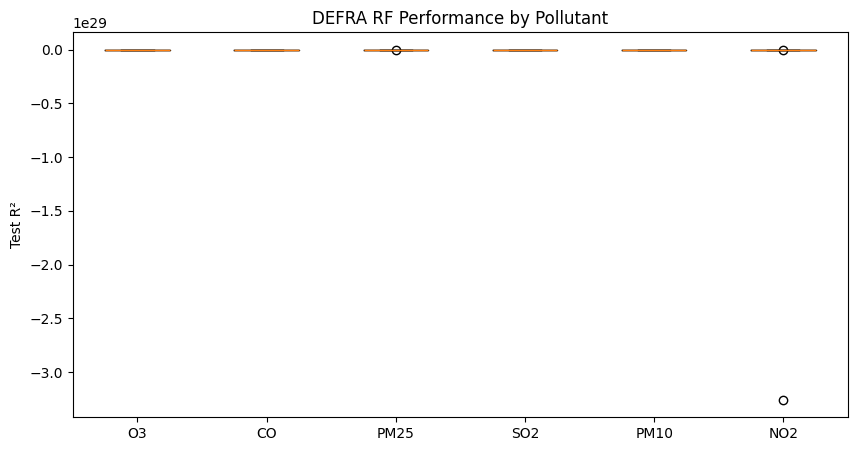

In [13]:
if checkpoint_file.exists():
    checkpoint_file.unlink()
    print("Checkpoint removed.")
print(f"All outputs in: {rf_output_dir}")

Checkpoint removed.
All outputs in: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all


In [14]:
# Find broken RF models
broken = results_df[results_df['test_r2'] < -1]
print(f"Broken models: {len(broken)}")
print(broken[['target', 'pollutant', 'test_r2']])

# Get real performance
good = results_df[results_df['test_r2'] > -1]
print(f"\nGood models: {len(good)}")
print(f"Real mean R²: {good['test_r2'].mean():.4f}")

# Real summary by pollutant
print("\nReal performance by pollutant:")
print(good.groupby('pollutant')['test_r2'].agg(['mean', 'std', 'count']).round(4))

Broken models: 1
                        target pollutant       test_r2
39  Tower_Hamlets_Roadside_NO2       NO2 -3.259004e+29

Good models: 39
Real mean R²: 0.7927

Real performance by pollutant:
             mean     std  count
pollutant                       
CO         0.8875  0.0401      2
NO2        0.8004  0.0536     12
O3         0.9106  0.0219      8
PM10       0.6641  0.1710      7
PM25       0.7611  0.2383      7
SO2        0.7585  0.2301      3


In [15]:
# Check Tower Hamlets data
target_name = 'Tower_Hamlets_Roadside_NO2'
idx = target_mapping[target_name]

print(f"{target_name} Data Check\n")

# Basic stats
print("Train set:")
print(f"  Min: {y_train[:, idx].min():.6f}")
print(f"  Max: {y_train[:, idx].max():.6f}")
print(f"  Mean: {y_train[:, idx].mean():.6f}")
print(f"  Std: {y_train[:, idx].std():.6f}")
print(f"  NaN count: {np.isnan(y_train[:, idx]).sum()}")
print(f"  Inf count: {np.isinf(y_train[:, idx]).sum()}")

print("\nTest set:")
print(f"  Min: {y_test[:, idx].min():.6f}")
print(f"  Max: {y_test[:, idx].max():.6f}")
print(f"  Mean: {y_test[:, idx].mean():.6f}")
print(f"  Std: {y_test[:, idx].std():.6f}")
print(f"  NaN count: {np.isnan(y_test[:, idx]).sum()}")
print(f"  Inf count: {np.isinf(y_test[:, idx]).sum()}")

# Check for constant values (causes R² issues)
print(f"\nUnique values in test: {len(np.unique(y_test[:, idx]))}")

# Compare with a working NO2 station
working_no2 = [t for t in target_mapping.keys() if 'NO2' in t and t != target_name][0]
working_idx = target_mapping[working_no2]
print(f"\nComparison with {working_no2} ")
print(f"  Test std: {y_test[:, working_idx].std():.6f}")
print(f"  Test unique: {len(np.unique(y_test[:, working_idx]))}")

Tower_Hamlets_Roadside_NO2 Data Check

Train set:
  Min: 0.000000
  Max: 1.000000
  Mean: 0.203130
  Std: 0.122847
  NaN count: 0
  Inf count: 0

Test set:
  Min: 0.181988
  Max: 0.181988
  Mean: 0.181988
  Std: 0.000000
  NaN count: 0
  Inf count: 0

Unique values in test: 1

Comparison with Borehamwood_Meadow_Park_NO2 
  Test std: 0.097430
  Test unique: 236


In [16]:
# Check validation set
print(f"Validation set:")
print(f"  Std: {y_val[:, idx].std():.6f}")
print(f"  Unique: {len(np.unique(y_val[:, idx]))}")

Validation set:
  Std: 0.101201
  Unique: 372


In [ ]:
target_name = 'Tower_Hamlets_Roadside_NO2'
idx = target_mapping[target_name]

# Get params for NO2
rf_params = safe_params_by_pollutant.get('NO2', {
    'n_estimators': 100, 'max_depth': 15,
    'min_samples_leaf': 2, 'min_samples_split': 5
}).copy()
rf_params['n_jobs'] = 1
rf_params['random_state'] = 42

# Train
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_rf, y_train[:, idx])

# Evaluate on VALIDATION set (since test has no variance)
y_pred_val = rf.predict(X_val_rf)
val_r2 = r2_score(y_val[:, idx], y_pred_val)
val_rmse = np.sqrt(mean_squared_error(y_val[:, idx], y_pred_val))
val_mae = mean_absolute_error(y_val[:, idx], y_pred_val)

print(f"Tower_Hamlets_Roadside_NO2 (using validation set):")
print(f"  R²:   {val_r2:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAE:  {val_mae:.4f}")

Tower_Hamlets_Roadside_NO2 (using validation set):
  R²:   0.9166
  RMSE: 0.0292
  MAE:  0.0217


In [ ]:
# Load results
results_df = pd.read_csv(rf_output_dir / 'all_results.csv')

# Filter to only valid R² values (e.g., R² > -10)
valid_results = results_df[results_df['test_r2'] > -10]

print(f"Total models: {len(results_df)}")
print(f"Valid models: {len(valid_results)}")
print(f"Broken models: {len(results_df) - len(valid_results)}")

# Show the broken ones
broken = results_df[results_df['test_r2'] <= -10]
print("\nBroken models:")
print(broken[['target', 'test_r2']])

Total models: 40
Valid models: 39
Broken models: 1

Broken models:
                        target       test_r2
39  Tower_Hamlets_Roadside_NO2 -3.259004e+29


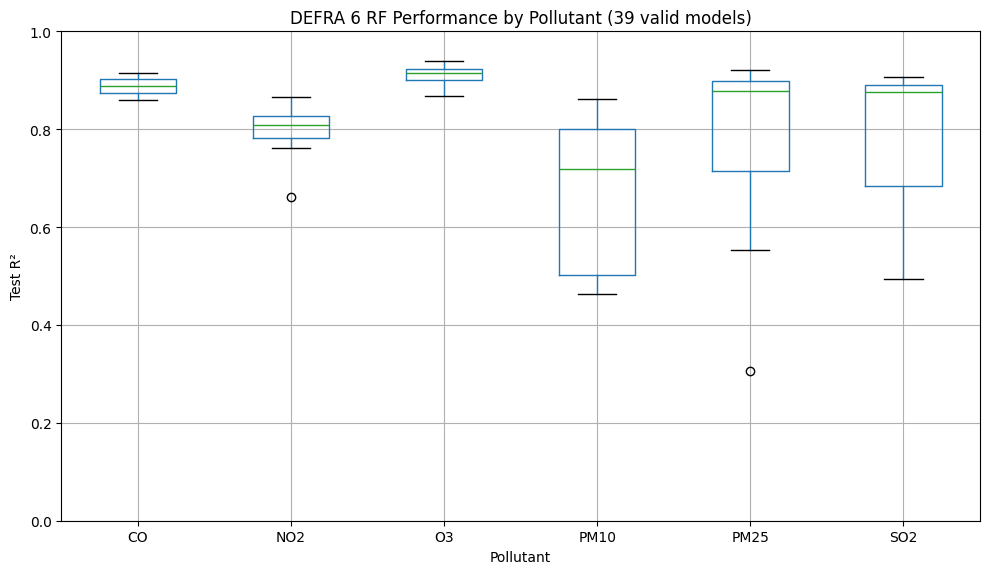


DEFRA 6 RF Summary (39 valid models):
               mean    median       std  count
pollutant                                     
CO         0.887466  0.887466  0.040088      2
NO2        0.800433  0.807714  0.053594     12
O3         0.910604  0.915334  0.021899      8
PM10       0.664144  0.719422  0.171047      7
PM25       0.761064  0.877214  0.238257      7
SO2        0.758477  0.875542  0.230068      3

Overall median R²: 0.855


In [ ]:
# Filter valid results only
valid_results = results_df[results_df['test_r2'] > -10].copy()

# Extract pollutant from target name (DEFRA format: Station_Name_Pollutant)
valid_results['pollutant'] = valid_results['target'].str.split('_').str[-1]

# Create boxplot with proper scale
fig, ax = plt.subplots(figsize=(10, 6))
valid_results.boxplot(column='test_r2', by='pollutant', ax=ax)
ax.set_title('DEFRA 6 RF Performance by Pollutant (39 valid models)')
ax.set_xlabel('Pollutant')
ax.set_ylabel('Test R²')
ax.set_ylim(0, 1)  # Set sensible y-axis limits
plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.savefig(rf_output_dir / 'rf_performance_by_pollutant_valid.png', dpi=150)
plt.show()

# Print summary stats
print("\nDEFRA 6 RF Summary (39 valid models):")
print(valid_results.groupby('pollutant')['test_r2'].agg(['mean', 'median', 'std', 'count']))
print(f"\nOverall median R²: {valid_results['test_r2'].median():.3f}")

Generating dissertation plots...

1. Aggregated plot (all models combined)


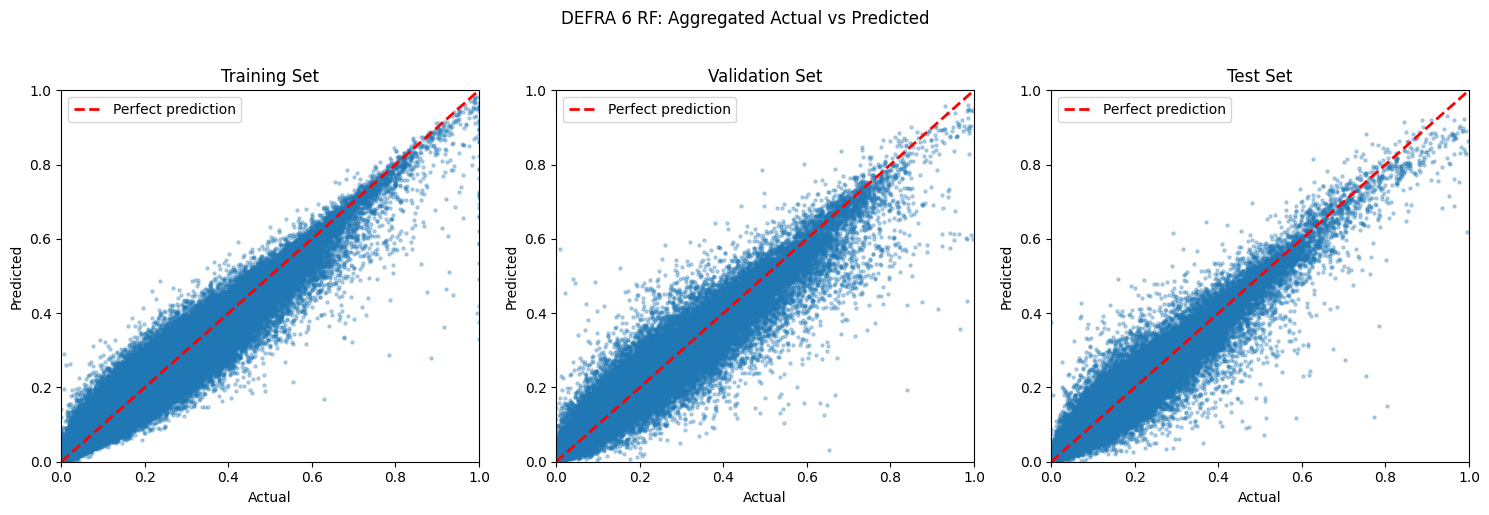

Saved: aggregated_actual_vs_predicted.png

2. Representative plots (one per pollutant)


NameError: name 'plot_actual_vs_predicted_3panel' is not defined

In [ ]:
# Define category function
def get_pollutant_category(name):
    pollutant = name.split('_')[-1]
    if pollutant in ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']:
        return pollutant
    return 'Other'

print("Generating dissertation plots...")

# Create output directory
plots_dir = rf_output_dir / 'dissertation_plots'
plots_dir.mkdir(exist_ok=True)

# Load results to find best/worst
results_df = pd.read_csv(rf_output_dir / 'all_results.csv')
valid_results = results_df[results_df['test_r2'] > -10]

# 1. Aggregated plot
print("\n1. Aggregated plot (all models combined)")

all_train_actual, all_train_pred = [], []
all_val_actual, all_val_pred = [], []
all_test_actual, all_test_pred = [], []

for i, target in enumerate(pollution_targets):
    if target not in all_models:
        continue
    model = all_models[target]
    
    all_train_actual.extend(y_train[:, i])
    all_train_pred.extend(model.predict(X_train_rf))
    all_val_actual.extend(y_val[:, i])
    all_val_pred.extend(model.predict(X_val_rf))
    all_test_actual.extend(y_test[:, i])
    all_test_pred.extend(model.predict(X_test_rf))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
datasets = [
    ('Training Set', all_train_actual, all_train_pred),
    ('Validation Set', all_val_actual, all_val_pred),
    ('Test Set', all_test_actual, all_test_pred)
]

for ax, (title, y_actual, y_pred) in zip(axes, datasets):
    ax.scatter(y_actual, y_pred, alpha=0.3, s=5)
    ax.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect prediction')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(title)
    ax.legend(loc='upper left')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.suptitle('DEFRA 6 RF: Aggregated Actual vs Predicted', y=1.02)
plt.tight_layout()
plt.savefig(plots_dir / 'aggregated_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: aggregated_actual_vs_predicted.png")

# 2. One representative per pollutant
print("\n2. Representative plots (one per pollutant)")
plotted_categories = {}

for target in pollution_targets:
    if target not in all_models:
        continue
    
    category = get_pollutant_category(target)
    if category in plotted_categories:
        continue
    
    target_idx = target_mapping[target]
    model = all_models[target]
    
    plot_actual_vs_predicted_3panel(
        model=model,
        X_train=X_train_rf, y_train=y_train[:, target_idx],
        X_val=X_val_rf, y_val=y_val[:, target_idx],
        X_test=X_test_rf, y_test=y_test[:, target_idx],
        target_name=target,
        save_path=plots_dir / f'representative_{category}.png'
    )
    
    plotted_categories[category] = target
    print(f"  {category}: {target}")

# 3. Best and worst performers
print("\n3. Best and worst performers")

best_model = valid_results.loc[valid_results['test_r2'].idxmax(), 'target']
worst_model = valid_results.loc[valid_results['test_r2'].idxmin(), 'target']

for label, target in [('best', best_model), ('worst', worst_model)]:
    target_idx = target_mapping[target]
    model = all_models[target]
    r2 = valid_results[valid_results['target'] == target]['test_r2'].values[0]
    
    plot_actual_vs_predicted_3panel(
        model=model,
        X_train=X_train_rf, y_train=y_train[:, target_idx],
        X_val=X_val_rf, y_val=y_val[:, target_idx],
        X_test=X_test_rf, y_test=y_test[:, target_idx],
        target_name=f"{target} (R²={r2:.3f})",
        save_path=plots_dir / f'{label}_performer.png'
    )
    print(f"  {label}: {target} (R²={r2:.3f})")

print(f"\nDone!")
print(f"Plots saved to: {plots_dir}")